<a href="https://colab.research.google.com/github/Alonsinho16/Redes-neuronales/blob/main/Proyecto_de_Redes_Neuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#Lectura y tratamiento de datos
import pandas as pd
import numpy as np

#Gráficos
import seaborn as sns
import matplotlib.pyplot as plt

#modelos
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report



In [ ]:
###Alonso Apreza Sies
Redes Neuronales
Proyecto sobre la estimación del VIH apartir de la AG (Autodetección) aparente usando el modelo LSTM y la base de datos de Kaggle:
#Determinaremos los conceptos de los valores adquiridos en el analisis de datos del VIH en un periodo de 2023, para ello tomaremos en cuneta cada uno de importantes datos obtenidos en:
"https://www.kaggle.com/datasets/tavoglc/vih-fragments-frequency"

In [3]:
#Especificar la ruta del dataset
!kaggle datasets download -d fedesoriano/vih-fragments-frequency

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1734, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [4]:
# Se puede notar que la base de datos cuenta únicamente con caracteres alfanuméricos y especiales, por lo que un modelo de Redes Neuronales Recurrentes (RNN) óptimo para el tratamiento de estos caracteres sería LSTM(Long Short-Term Memory). Una buena forma de tratar con estos datos es haciéndoles una "traducción" a vectores numéricos con una codificación.

# Las URL's se traducirán a vectores, por lo que se debe tener en cuenta de que todos los vectores deben de ser de la misma dimensión antes de ser tratados mediante el modelo LSTM.

# Las etiquetas benign, defacement, phishing y malware, se utilizarán números del 0 al 4 para darles una clasificación.

In [6]:
import pandas as pd

# Assuming your dataset file is named 'KmerDatacsv'
df = pd.read_csv('KmerData.csv')

# Now you can access columns like this:
Code = df["id"].astype(str)
Autodeteccion = df["AG"]

In [6]:
tokenizer = Tokenizer(char_level=True)   #char_level=true hace que se puedan interpretar caracteres especiales como /,-,_,=...
tokenizer.fit_on_texts(Code)

#Se convierte cada URL en una secuencia
url_sec=tokenizer.texts_to_sequences(Code)

#Y se rellenan los espacios faltantes de las URL's "pequeñas". PE: una URL de 10 caracteres tendrá una dimensión menor que una de 50 caracteres
maxlen=max(len(seq) for seq in url_sec)
X=pad_sequences(url_sec, maxlen=maxlen, padding="post")   #pad_sequences rellena con ceros al final (padding="post") de las URL's

#miramos las primeras dos secuencias
X[:2]

array([[15, 30, 37,  2,  2,  1, 11,  2,  3],
       [ 4, 24,  1,  8,  5,  5, 10, 11,  0]], dtype=int32)

In [7]:
Y = df['id'].map({"benign": 0, "defacement": 1, "phishing": 2, "malware": 3}).values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

vocab_size=len(tokenizer.word_index) + 1  # número total de caracteres + 1 para ceros rellenados
embedding_dim=32                          # tamaño del vector que representará cada carácter
input_length=X.shape[1]                   # longitud de todas las secuencias tras haber rellenado con ceros

model=Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(4, activation="softmax"))
model.build(input_shape=(None, input_length))

model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 9, 32)          │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 9, 100)         │        53,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,220 (528.20 KB)

 Trainable params: 135,220 (528.20 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
print(df['AG'].unique())

[0.10578494 0.10454444 0.10208451 ... 0.10491188 0.10379384 0.10578699]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

vocab_size=len(tokenizer.word_index) + 1  # número total de caracteres + 1 para ceros rellenados
embedding_dim=32                          # tamaño del vector que representará cada carácter
input_length=X.shape[1]                   # longitud de todas las secuencias tras haber rellenado con ceros

model=Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(4, activation="softmax"))
model.build(input_shape=(None, input_length))

model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 9, 32)          │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 9, 100)         │        53,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 9, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,220 (528.20 KB)

 Trainable params: 135,220 (528.20 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [18]:
df.isna().sum()


,0
id,0
A,0
C,0
T,0
G,0
...,...
GGTG,0
GGGA,0
GGGC,0
GGGT,0


In [7]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21696 entries, 0 to 21695
Columns: 341 entries, id to GGGG
dtypes: float64(340), object(1)
memory usage: 56.4+ MB


,A,C,T,G,AA,AC,AT,AG,CA,CC,...,GGCT,GGCG,GGTA,GGTC,GGTT,GGTG,GGGA,GGGC,GGGT,GGGG
count,21696.000000,21696.000000,21696.000000,21696.000000,21696.000000,21696.000000,21696.000000,21696.000000,21696.000000,21696.000000,...,21696.000000,21696.000000,21696.000000,21696.000000,21696.000000,21696.000000,21696.000000,21696.000000,21696.000000,21696.000000
mean,0.365430,0.175584,0.222945,0.235736,0.124648,0.057872,0.077811,0.105002,0.082918,0.039539,...,0.002745,0.000855,0.002924,0.001244,0.002180,0.002255,0.007219,0.003109,0.002583,0.005715
std,0.014816,0.012422,0.018838,0.011828,0.010133,0.004138,0.004040,0.005870,0.005921,0.003290,...,0.000490,0.000310,0.000623,0.000327,0.000753,0.000456,0.001936,0.000703,0.000798,0.001338
min,0.204943,0.000000,0.207655,0.115268,0.045863,0.000000,0.059282,0.042736,0.000000,0.000000,...,0.000000,0.000000,0.000111,0.000000,0.000111,0.000225,0.000111,0.000000,0.000000,0.000222
25%,0.360636,0.174511,0.220088,0.236586,0.121045,0.057310,0.076197,0.103145,0.082248,0.038775,...,0.002453,0.000670,0.002584,0.001023,0.001920,0.002025,0.007346,0.003003,0.002526,0.005616
50%,0.363213,0.176290,0.221433,0.239123,0.123021,0.058160,0.077479,0.104410,0.083398,0.039660,...,0.002671,0.000884,0.002951,0.001232,0.002209,0.002317,0.007757,0.003240,0.002781,0.006057
75%,0.366828,0.177832,0.222646,0.241193,0.125806,0.058969,0.078870,0.105721,0.084490,0.040445,...,0.003010,0.001017,0.003240,0.001443,0.002439,0.002551,0.008144,0.003483,0.002979,0.006388
max,0.487775,0.250796,0.607275,0.256181,0.282768,0.064834,0.139916,0.124655,0.089640,0.073587,...,0.006003,0.005993,0.011009,0.004904,0.015267,0.006647,0.010041,0.005152,0.007726,0.012991


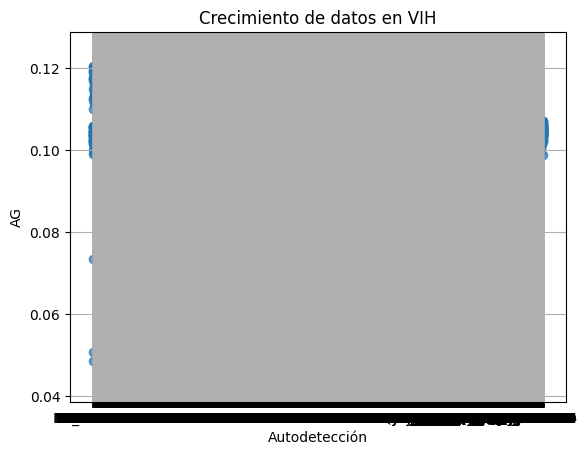

In [8]:
plt.scatter(df["id"], df["AG"], alpha=0.7)
plt.xlabel("Autodetección")
plt.ylabel("AG")
plt.title("Crecimiento de datos en VIH")
plt.grid(True)
plt.show()

array([[<Axes: title={'center': 'A'}>, <Axes: title={'center': 'C'}>,
        <Axes: title={'center': 'T'}>, <Axes: title={'center': 'G'}>,
        <Axes: title={'center': 'AA'}>, <Axes: title={'center': 'AC'}>,
        <Axes: title={'center': 'AT'}>, <Axes: title={'center': 'AG'}>,
        <Axes: title={'center': 'CA'}>, <Axes: title={'center': 'CC'}>],
       [<Axes: title={'center': 'CT'}>, <Axes: title={'center': 'CG'}>,
        <Axes: title={'center': 'TA'}>, <Axes: title={'center': 'TC'}>,
        <Axes: title={'center': 'TT'}>, <Axes: title={'center': 'TG'}>,
        <Axes: title={'center': 'GA'}>, <Axes: title={'center': 'GC'}>,
        <Axes: title={'center': 'GT'}>, <Axes: title={'center': 'GG'}>],
       [<Axes: title={'center': 'AAA'}>, <Axes: title={'center': 'AAC'}>,
        <Axes: title={'center': 'AAT'}>, <Axes: title={'center': 'AAG'}>,
        <Axes: title={'center': 'ACA'}>, <Axes: title={'center': 'ACC'}>,
        <Axes: title={'center': 'ACT'}>, <Axes: title={'cent

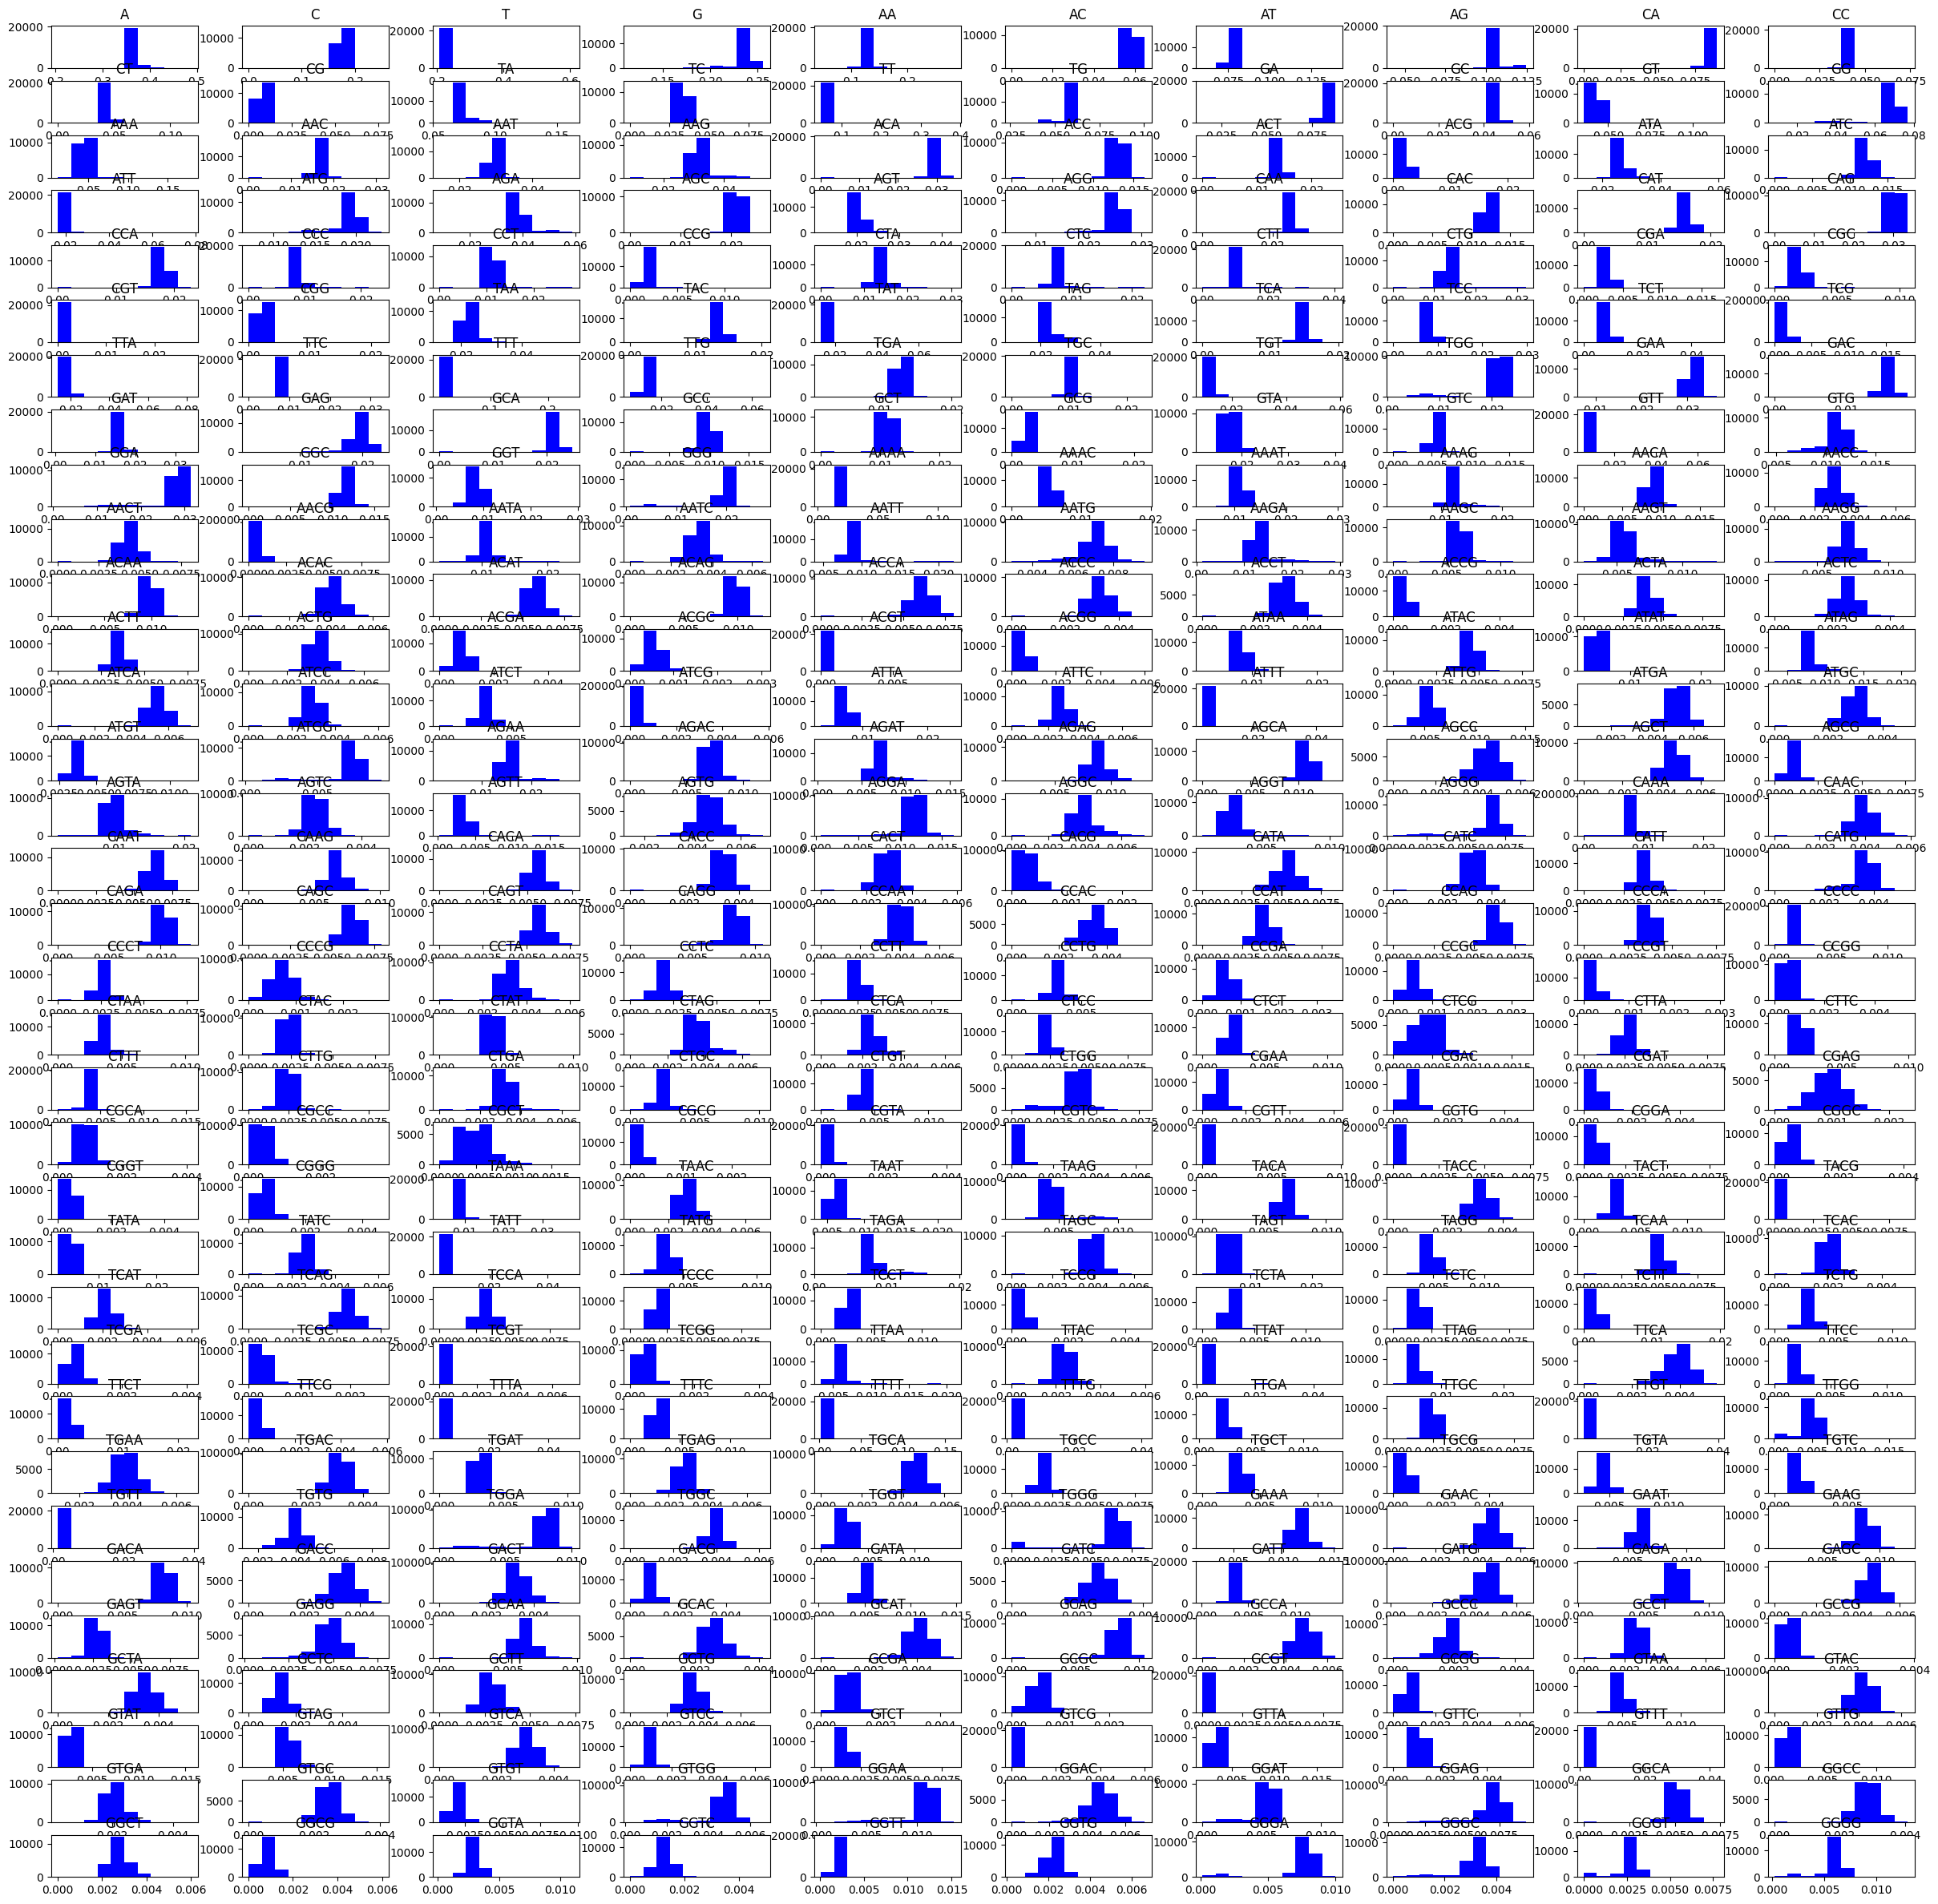

In [10]:
df.hist(figsize=(30,30), layout=(34,10), color='blue', grid= False)

In [20]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['id_encoded'] = encoder.fit_transform(df['id'])
correlation = df['id_encoded'].corr(df['AG'])
print("Correlación id - AG:", correlation)

Correlación id - AG: 0.10978147177242245


In [23]:
############# Escalado de datos ####################
from sklearn.preprocessing import MinMaxScaler # Importing MinMaxScaler
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder

# Ordenar por redshift para mantener consistencia en series temporales
df = df.sort_values('id').reset_index(drop=True)

# Encode 'id' column to numerical using LabelEncoder
encoder = LabelEncoder()
df['id_encoded'] = encoder.fit_transform(df['id'])

# Escalar ambos atributos using 'id_encoded' instead of 'id'
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['AG', 'id_encoded']]) # Use 'id_encoded'

# Crear secuencias de temporales, datos para el entrenamiento
def create_dataset(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        # Solo usamos la magnitud aparente como entrada
        X.append(data[i:i+time_steps, 0])  # columna 0 = magnitud aparente
        y.append(data[i+time_steps, 1])    # columna 1 = redshift (now 'id_encoded')
    return np.array(X), np.array(y)

# Crear dataset
X, y = create_dataset(df_scaled, time_steps=10)
# Adaptar forma para LSTM: [muestras, pasos de tiempo, características]
X = X.reshape((X.shape[0], X.shape[1], 1))

In [24]:
# Modelo LSTM
model = Sequential([
    LSTM(50, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),  #return_sequences=True Devuelve salidas para cada paso (necesario para apilar LSTM)
    Dropout(0.2), #evita el sobreajuste , apaga aleatoriamete el 20% de las neuronas durante el entrenamiento#
    LSTM(100, return_sequences=False), #return sequences = False nos da la salid final y no toda la secuencia
    Dense(1) #capa final densa
])
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,901 (276.96 KB)

 Trainable params: 70,901 (276.96 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Entrenar el modelo
history = model.fit(X, y, epochs=50, batch_size=16, verbose=1)

Epoch 1/50
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.0000e+00 - loss: 0.0898
Epoch 2/50
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0833
Epoch 3/50
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - accuracy: 1.3823e-04 - loss: 0.0833
Epoch 4/50
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 43s 18ms/step - accuracy: 1.9991e-05 - loss: 0.0828
Epoch 5/50
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 39s 17ms/step - accuracy: 3.5882e-04 - loss: 0.0830
Epoch 6/50
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0878
Epoch 7/50
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 5.5764e-05 - loss: 0.0843
Epoch 8/50
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 6.6056e-05 - loss: 0.0825
Epoch 9/50
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 3.1595e-06 - loss: 0.0828
Epoch 10/50
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0823
Epoch 11/50
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 53s 24ms/step - 

In [28]:
# Hacer predicciones
pred_scaled = model.predict(X)

# Reconstruir el array para invertir el escalado
# Insertamos las predicciones en la columna 1 (id)
zeros = np.zeros((len(pred_scaled), 2))
zeros[:, 1] = pred_scaled[:, 0]

# Invertimos escalado
pred_id = scaler.inverse_transform(zeros)
pred_AG = pred_id[:, 1] # Changed pred_inv to pred_id

# También invertimos los valores reales de redshift para comparar
y_full = np.zeros((len(y), 2))
y_full[:, 1] = y
y_real = scaler.inverse_transform(y_full)[:, 1]

678/678 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


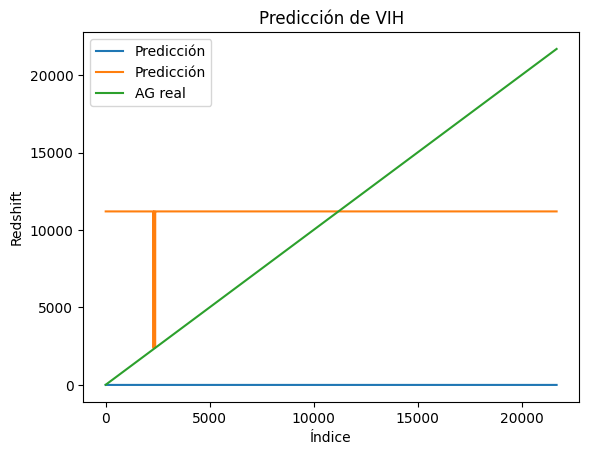

In [29]:
import matplotlib.pyplot as plt

plt.plot(pred_id, label='Predicción')
plt.plot(y_real, label='AG real')
plt.legend()
plt.title("Predicción de VIH")
plt.xlabel("Índice")
plt.ylabel("Redshift")
plt.show()

In [32]:
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

# Assuming pred_redshift should be pred_AG
r2 = r2_score(y_real, pred_AG)
print(f"R² score: {r2:.4f}")

R² score: 0.0027


In [34]:
!pip install plotly
import plotly.graph_objects as go

fig = go.Figure()

# Línea real
fig.add_trace(go.Scatter(
    y=y_real,
    mode='lines',
    name='Redshift real',
    line=dict(color='blue')
))

# Línea de predicción
fig.add_trace(go.Scatter(
    y=pred_AG,  # Changed pred_redshift to pred_AG
    mode='lines',
    name='Predicción',
    line=dict(color='red')
))

# Título y ejes
fig.update_layout(
    title=f"Predicción de redshift (R² = {r2:.4f})",
    xaxis_title="Índice de muestra",
    yaxis_title="Redshift",
    template='plotly_dark'
)

fig.show()